# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_and_log"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.007439,0.012454,0.597337,0.550303,0.275152,random.pheno988
1,LV2,0.016581,0.012455,1.331233,0.183160,0.091580,random.pheno988
2,LV3,-0.010470,0.012465,-0.839929,0.400979,0.799510,random.pheno988
3,LV4,-0.013447,0.012465,-1.078745,0.280742,0.859629,random.pheno988
4,LV5,0.002138,0.012454,0.171673,0.863700,0.431850,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.0606048632218845

# QQ-plot

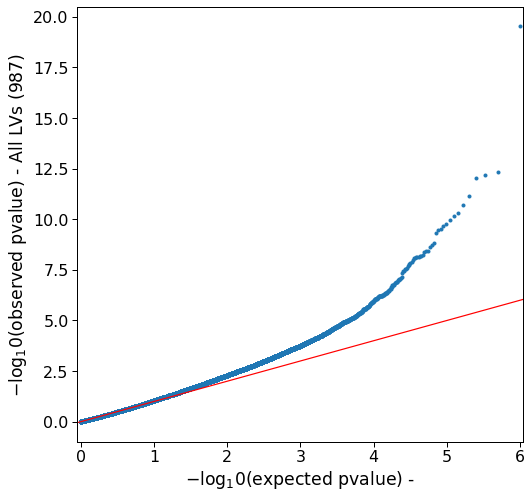

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.037,0.064
1,LV10,0.013,0.049,0.084
2,LV100,0.018,0.051,0.098
3,LV101,0.018,0.051,0.095
4,LV102,0.011,0.057,0.100


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016740,0.060605,0.108825
std,0.008017,0.015723,0.022177
min,0.002000,0.015000,0.032000
25%,0.012000,0.050000,0.095000
50%,0.016000,0.059000,0.108000
75%,0.020000,0.069000,0.121500
max,0.103000,0.158000,0.224000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(84, 4)

,lv,1,5,10
1,LV10,0.013,0.049,0.084
626,LV663,0.011,0.049,0.090
221,LV299,0.013,0.049,0.093
617,LV655,0.012,0.049,0.089
609,LV648,0.007,0.049,0.086
285,LV356,0.014,0.049,0.101
294,LV364,0.007,0.049,0.079
415,LV473,0.016,0.049,0.114
608,LV647,0.009,0.049,0.086
532,LV579,0.012,0.049,0.097


,lv,1,5,10
432,LV489,0.007,0.051,0.097
136,LV221,0.013,0.051,0.105
450,LV504,0.017,0.051,0.083
397,LV457,0.007,0.051,0.097
976,LV979,0.013,0.051,0.105
470,LV522,0.017,0.051,0.092
347,LV411,0.013,0.051,0.110
523,LV570,0.015,0.051,0.088
524,LV571,0.009,0.051,0.102
757,LV781,0.012,0.051,0.099


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(466, 4)

,lv,1,5,10
850,LV865,0.023,0.094,0.146
949,LV954,0.025,0.095,0.157
631,LV668,0.034,0.097,0.163
213,LV291,0.042,0.099,0.142
382,LV443,0.042,0.100,0.133
142,LV227,0.043,0.101,0.141
28,LV124,0.036,0.101,0.150
471,LV523,0.032,0.102,0.174
557,LV600,0.034,0.102,0.180
961,LV965,0.038,0.103,0.160


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.004425,0.012458,0.355202,0.722450,0.361225,random.pheno988
1031,LV45,0.001227,0.012466,0.098423,0.921599,0.460800,random.pheno589
2018,LV45,-0.000221,0.012464,-0.017696,0.985882,0.507059,random.pheno385
3005,LV45,0.007113,0.012464,0.570625,0.568274,0.284137,random.pheno5
3992,LV45,-0.009369,0.012464,-0.751696,0.452262,0.773869,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.103

In [31]:
show_prop(results, 0.05)

0.158

In [32]:
show_prop(results, 0.10)

0.224

In [33]:
show_prop(results, 0.15)

0.265

In [34]:
show_prop(results, 0.20)

0.291

### QQplot

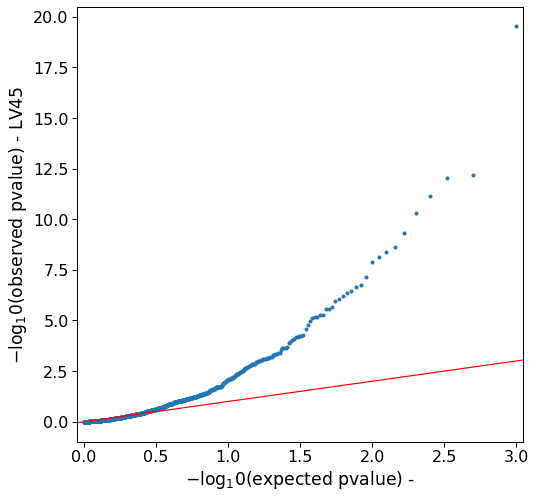

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.002964,0.012475,0.237583,0.812212,0.406106,random.pheno988
1220,LV234,-0.001368,0.012482,-0.109558,0.912764,0.543618,random.pheno589
2207,LV234,0.001975,0.012481,0.158250,0.874265,0.437132,random.pheno385
3194,LV234,0.013493,0.012480,1.081095,0.279695,0.139848,random.pheno5
4181,LV234,0.011509,0.012481,0.922154,0.356483,0.178241,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.086

In [42]:
show_prop(results, 0.05)

0.153

In [43]:
show_prop(results, 0.10)

0.211

In [44]:
show_prop(results, 0.15)

0.241

In [45]:
show_prop(results, 0.20)

0.285

### QQplot

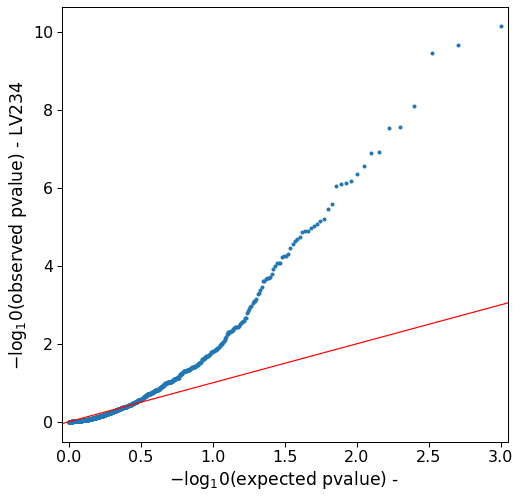

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.005754,0.012473,-0.461291,0.644605,0.677697,random.pheno988
1833,LV847,0.001454,0.012481,0.116517,0.907246,0.453623,random.pheno589
2820,LV847,-0.003578,0.012480,-0.286664,0.774379,0.612810,random.pheno385
3807,LV847,0.008734,0.012480,0.699811,0.484071,0.242035,random.pheno5
4794,LV847,0.014349,0.012479,1.149817,0.250262,0.125131,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.09

In [53]:
show_prop(results, 0.05)

0.141

In [54]:
show_prop(results, 0.10)

0.193

In [55]:
show_prop(results, 0.15)

0.219

In [56]:
show_prop(results, 0.20)

0.261

### QQplot

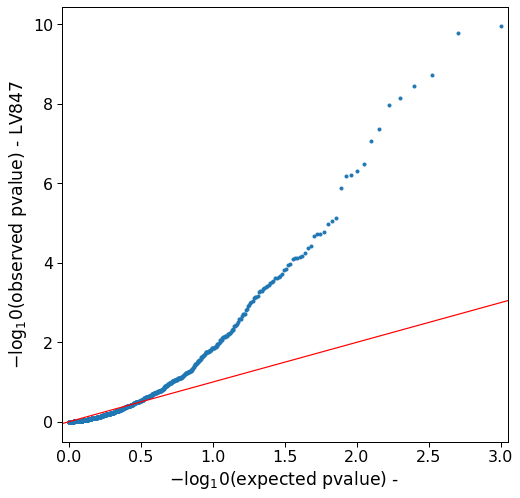

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.025531,0.012470,-2.047435,0.040656,0.979672,random.pheno988
1096,LV110,0.000769,0.012482,0.061585,0.950896,0.475448,random.pheno589
2083,LV110,-0.005204,0.012481,-0.416984,0.676704,0.661648,random.pheno385
3070,LV110,-0.005355,0.012481,-0.429047,0.667904,0.666048,random.pheno5
4057,LV110,0.009727,0.012480,0.779358,0.435798,0.217899,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.079

In [64]:
show_prop(results, 0.05)

0.124

In [65]:
show_prop(results, 0.10)

0.176

In [66]:
show_prop(results, 0.15)

0.217

In [67]:
show_prop(results, 0.20)

0.245

### QQplot

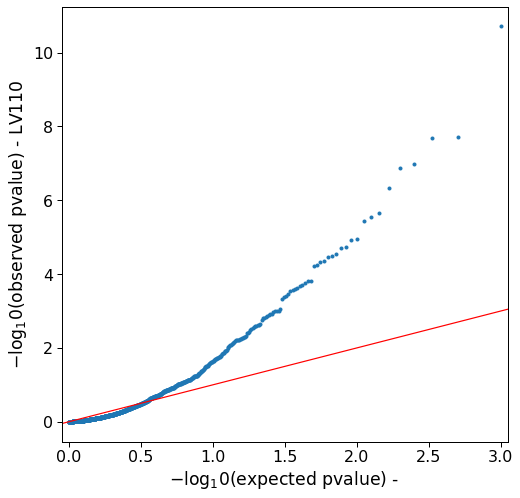

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.013760,0.012463,1.104137,0.269575,0.134787,random.pheno988
1755,LV769,0.001245,0.012472,0.099818,0.920492,0.460246,random.pheno589
2742,LV769,0.002691,0.012470,0.215760,0.829182,0.414591,random.pheno385
3729,LV769,-0.020895,0.012468,-1.675884,0.093809,0.953095,random.pheno5
4716,LV769,-0.018490,0.012469,-1.482909,0.138148,0.930926,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.039

In [75]:
show_prop(results, 0.05)

0.124

In [76]:
show_prop(results, 0.10)

0.196

In [77]:
show_prop(results, 0.15)

0.253

In [78]:
show_prop(results, 0.20)

0.312

### QQplot

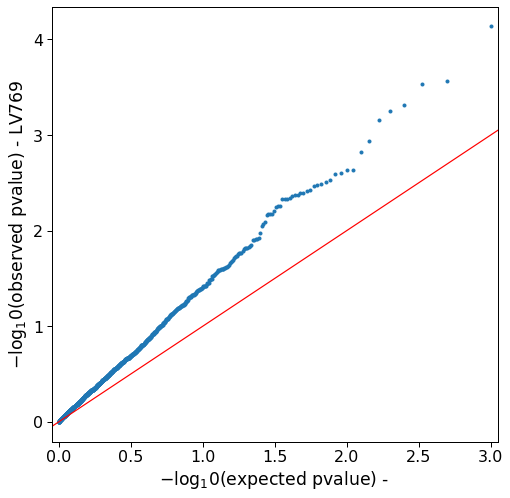

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.013495,0.012472,1.082028,0.279281,0.139640,random.pheno988
1786,LV800,0.002792,0.012481,0.223718,0.822984,0.411492,random.pheno589
2773,LV800,-0.009387,0.012479,-0.752190,0.451964,0.774018,random.pheno385
3760,LV800,-0.021534,0.012477,-1.725884,0.084416,0.957792,random.pheno5
4747,LV800,-0.008309,0.012480,-0.665830,0.505544,0.747228,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.05

In [86]:
show_prop(results, 0.05)

0.124

In [87]:
show_prop(results, 0.10)

0.185

In [88]:
show_prop(results, 0.15)

0.219

In [89]:
show_prop(results, 0.20)

0.266

### QQplot

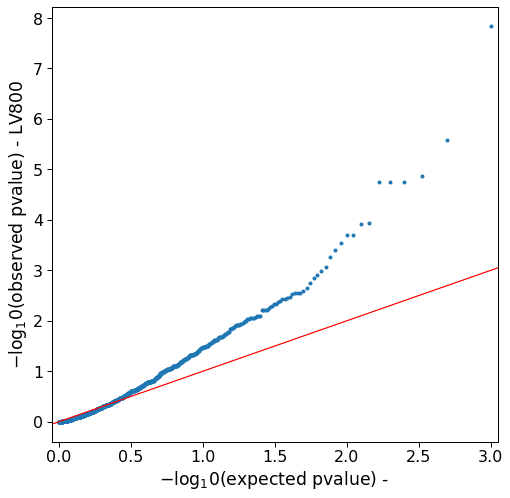

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
1,LV10,0.013,0.049,0.084
626,LV663,0.011,0.049,0.090
221,LV299,0.013,0.049,0.093
617,LV655,0.012,0.049,0.089
609,LV648,0.007,0.049,0.086
285,LV356,0.014,0.049,0.101
294,LV364,0.007,0.049,0.079
415,LV473,0.016,0.049,0.114
608,LV647,0.009,0.049,0.086
532,LV579,0.012,0.049,0.097


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.009742,0.012456,-0.782060,0.434208,0.782896,random.pheno988
1398,LV412,-0.015910,0.012463,-1.276573,0.201799,0.899101,random.pheno589
2385,LV412,0.019752,0.012461,1.585082,0.112997,0.056498,random.pheno385
3372,LV412,0.009495,0.012463,0.761846,0.446180,0.223090,random.pheno5
4359,LV412,0.010256,0.012463,0.822919,0.410584,0.205292,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.009

In [99]:
show_prop(results, 0.05)

0.049

In [100]:
show_prop(results, 0.10)

0.103

In [101]:
show_prop(results, 0.15)

0.144

In [102]:
show_prop(results, 0.20)

0.185

### QQplot

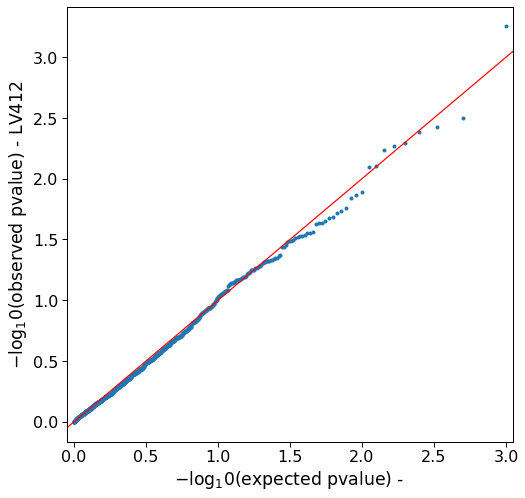

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.022663,0.012486,-1.815064,0.069561,0.965220,random.pheno988
1043,LV57,0.024202,0.012493,1.937194,0.052765,0.026383,random.pheno589
2030,LV57,0.014644,0.012494,1.172036,0.241226,0.120613,random.pheno385
3017,LV57,-0.003333,0.012496,-0.266714,0.789698,0.605151,random.pheno5
4004,LV57,0.013363,0.012495,1.069446,0.284909,0.142454,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.015

In [110]:
show_prop(results, 0.05)

0.047

In [111]:
show_prop(results, 0.10)

0.099

In [112]:
show_prop(results, 0.15)

0.136

In [113]:
show_prop(results, 0.20)

0.19

### QQplot

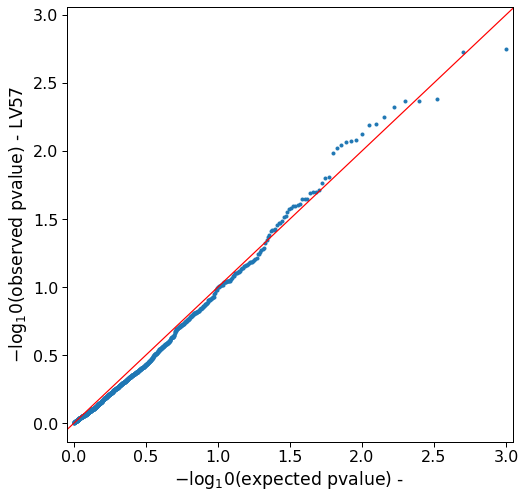

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.008069,0.012455,-0.647842,0.517110,0.741445,random.pheno988
1633,LV647,0.000187,0.012464,0.014997,0.988035,0.494018,random.pheno589
2620,LV647,-0.000799,0.012462,-0.064099,0.948893,0.525553,random.pheno385
3607,LV647,0.003853,0.012463,0.309183,0.757192,0.378596,random.pheno5
4594,LV647,0.004316,0.012463,0.346354,0.729088,0.364544,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.009

In [121]:
show_prop(results, 0.05)

0.049

In [122]:
show_prop(results, 0.10)

0.086

In [123]:
show_prop(results, 0.15)

0.136

In [124]:
show_prop(results, 0.20)

0.17

### QQplot

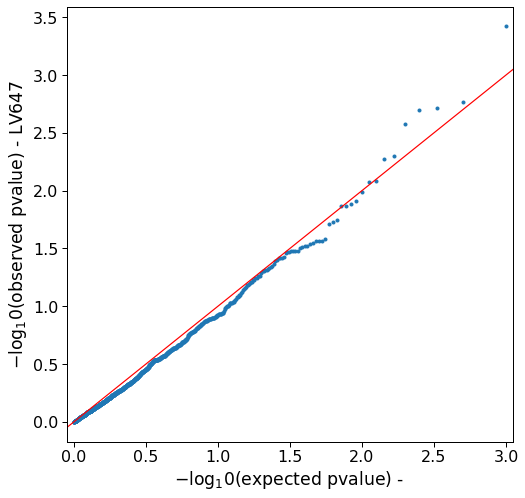

In [125]:
qqplot_unif(results)